In [1350]:
# Importing the libraries
import glob
from time import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [1351]:
# Read all the csv files in the folder
data_list = glob.glob('Airbnb Prices in Europe/*.csv')

# Now we can use pandas to read all the csv files and combine them into one
df = pd.concat(map(pd.read_csv, data_list))

# Cross-Featuring the longitude and latitude
df['lng-lat'] = df['lng'] * df['lat'] / 1000000

# Drop the index column
df.drop(['Unnamed: 0', 'rest_index_norm', 'attr_index_norm', 'room_private', 'room_shared', 'cleanliness_rating', 'lng', 'lat'], axis=1, inplace=True)

# Check if there are any null values
df.isnull().sum()

realSum                       0
room_type                     0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
rest_index                    0
lng-lat                       0
dtype: int64

<Axes: >

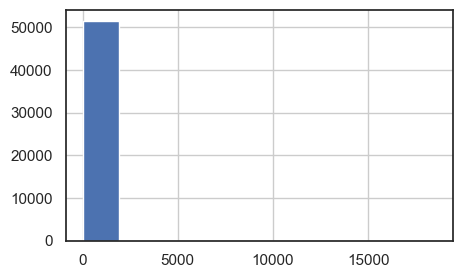

In [1352]:
# Visualize the distribution of the prices
plt.figure(figsize=(5, 3))
df.realSum.hist()

In [1353]:
# Calculate the statistics of the prices
df.realSum.describe()

count    51707.000000
mean       279.879591
std        327.948386
min         34.779339
25%        148.752174
50%        211.343089
75%        319.694287
max      18545.450285
Name: realSum, dtype: float64

In [1354]:
# Calculate the distribution of the prices
bins = [0, 50, 100, 150, 200, 350, 500, 1000, 1500, 2500, 3000, 3500, int(df.realSum.max())]
bin_counts = pd.cut(df.realSum, bins).value_counts()
bin_percentages = bin_counts / df.shape[0] * 100
hist_df = pd.DataFrame({'range': bin_percentages.index, '%': bin_percentages.values})
hist_df = hist_df.sort_values('range')
hist_df

,range,%
8,"(0, 50]",0.096699
5,"(50, 100]",5.883149
2,"(100, 150]",19.589224
1,"(150, 200]",20.521399
0,"(200, 350]",32.889164
3,"(350, 500]",10.990775
4,"(500, 1000]",8.538496
6,"(1000, 1500]",0.992129
7,"(1500, 2500]",0.348115
10,"(2500, 3000]",0.048349


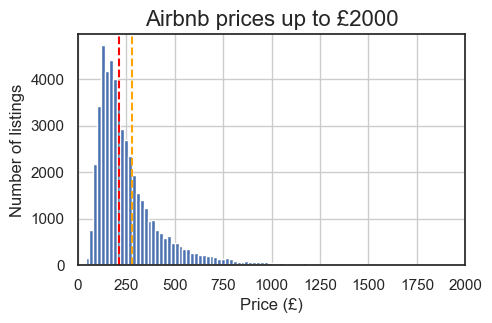

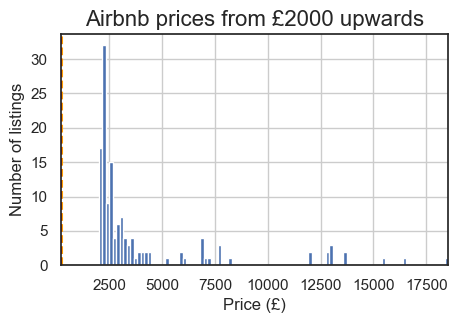

In [1355]:
# Visualize the distribution of the prices up to £1500
plt.figure(figsize=(5, 3))
df.realSum.hist(bins=100, range=(0, 2000))
plt.margins(x=0)
plt.axvline(df.realSum.mean(), color='orange', linestyle='--')
plt.axvline(df.realSum.median(), color='red', linestyle='--')
plt.title("Airbnb prices up to £2000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

# Visualize the distribution of the prices from £2000 upwards
plt.figure(figsize=(5, 3))
df.realSum.hist(bins=100, range=(2000, max(df.realSum)))
plt.margins(x=0)
plt.axvline(df.realSum.mean(), color='orange', linestyle='--')
plt.axvline(df.realSum.median(), color='red', linestyle='--')
plt.title("Airbnb prices from £2000 upwards", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

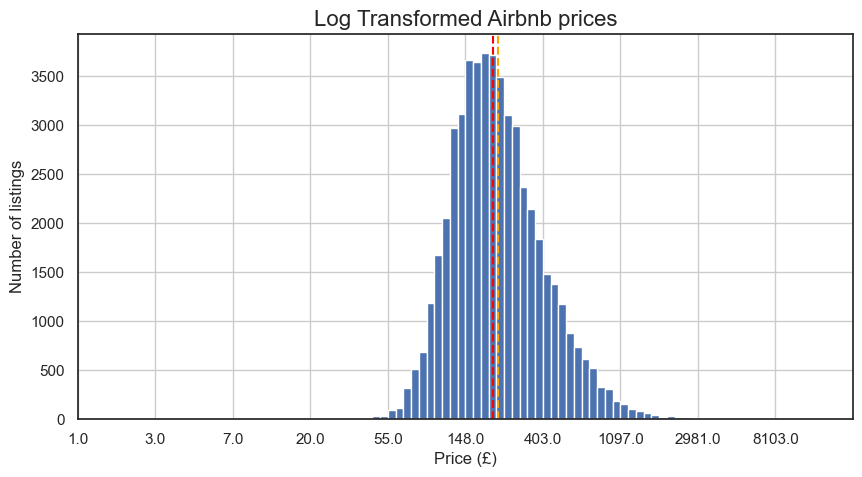

In [1356]:
plt.figure(figsize=(10,5))
np.log(df.realSum).hist(bins=100, range=(0, 10))
plt.margins(x=0)

# Change the x-axis to show the actual price rounded to the nearest £
plt.xticks(np.arange(0, 10, step=1), np.exp(np.arange(0, 10, step=1)).round())

plt.axvline(np.log(df.realSum).mean(), color='orange', linestyle='--')
plt.axvline(np.log(df.realSum).median(), color='red', linestyle='--')
plt.title("Log Transformed Airbnb prices", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [1357]:
# Based on the log transformed data drop the rows with price over £2000 a
df = df[(df.realSum <= 2000) & (df.realSum >= 55)]

<Axes: >

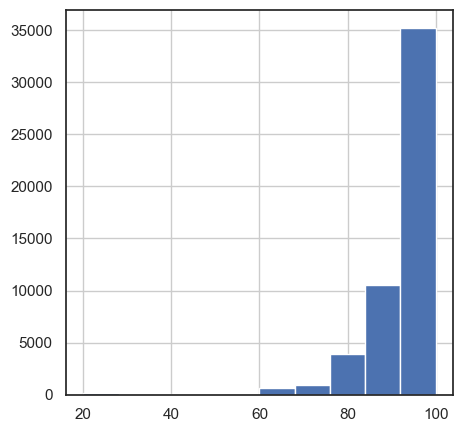

In [1358]:
# Visualizing the distribution of the satisfaction rating
df.guest_satisfaction_overall.hist(figsize=(5, 5))

In [1359]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [1360]:
# Binning cleanliness_rating column into 3 bins
bin_column('guest_satisfaction_overall',
               bins=[0, 80, 95, 100],
               labels=['0-79/100', '80-94/100', '95-100/100'],
               na_label='no reviews')

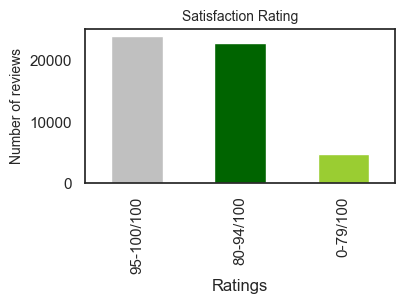

In [1361]:
# Set the size of the figure
fig, ax = plt.subplots(1, 1, figsize=(4,2))

# Plot the barplot
ax.set_title('Satisfaction Rating', fontsize=10)

# Plot the barplot
df['guest_satisfaction_overall'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of reviews', fontsize=10)
plt.show()

In [1362]:
# Get the numeric columns by excluding the categorical columns
num_cols = ['realSum', 'person_capacity', 'bedrooms', 'metro_dist', 'dist', 'lng-lat', 'rest_index', 'attr_index']

# Get the categorical columns by excluding df columns from the numeric columns
cat_cols = [col for col in df.columns if col not in num_cols]

# Get dummy variables for categorical and boolean columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check the first 5 rows of the dataframe
df.head()

,realSum,person_capacity,bedrooms,dist,metro_dist,attr_index,rest_index,lng-lat,room_type_Private room,room_type_Shared room,host_is_superhost_True,multi_1,biz_1,guest_satisfaction_overall_80-94/100,guest_satisfaction_overall_95-100/100
0,194.033698,2.0,1,5.022964,2.539380,78.690379,98.253896,0.000257,1,0,0,1,0,1,0
1,344.245776,4.0,1,0.488389,0.239404,631.176378,837.280757,0.000257,1,0,0,0,0,1,0
2,264.101422,2.0,1,5.748312,3.651621,75.275877,95.386955,0.000261,1,0,0,0,1,1,0
3,433.529398,4.0,2,0.384862,0.439876,493.272534,875.033098,0.000256,1,0,0,0,1,1,0
4,485.552926,2.0,1,0.544738,0.318693,552.830324,815.305740,0.000257,1,0,1,0,0,0,1


/var/folders/71/krwvwqnd59748c6sr2hd_3mh0000gn/T/ipykernel_24602/2342598156.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


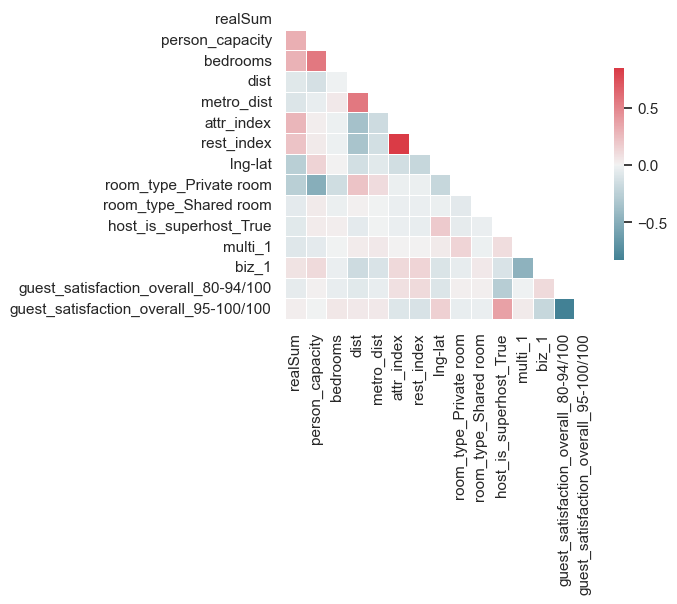

In [1363]:
# Set the style of the visualization
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the multi-collinear heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

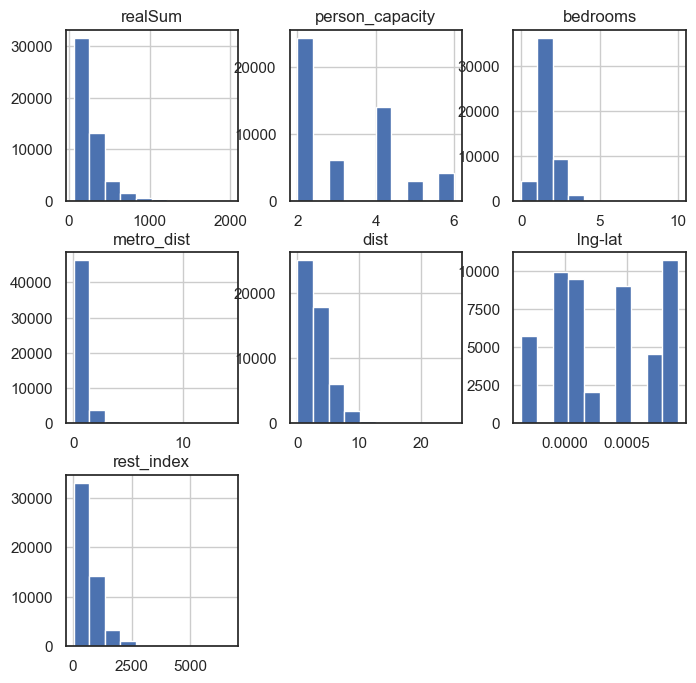

In [1364]:
# Remove attr_index from the list of numeric columns due to high correlation with rest_index
num_cols.remove('attr_index')

# Dropping the columns guest_satisfaction_overall_80-94/100 and attr_index
df.drop(['guest_satisfaction_overall_80-94/100', 'attr_index'], axis=1, inplace=True)

# Comparing the features distribution
df[num_cols].hist(figsize=(8, 8))
plt.show()

In [1365]:
# Log transform the numeric columns
for col in num_cols:
    df[col] = df[col].replace(0.0, 0.01)
    df[col] = np.log(df[col]+ 0.01)

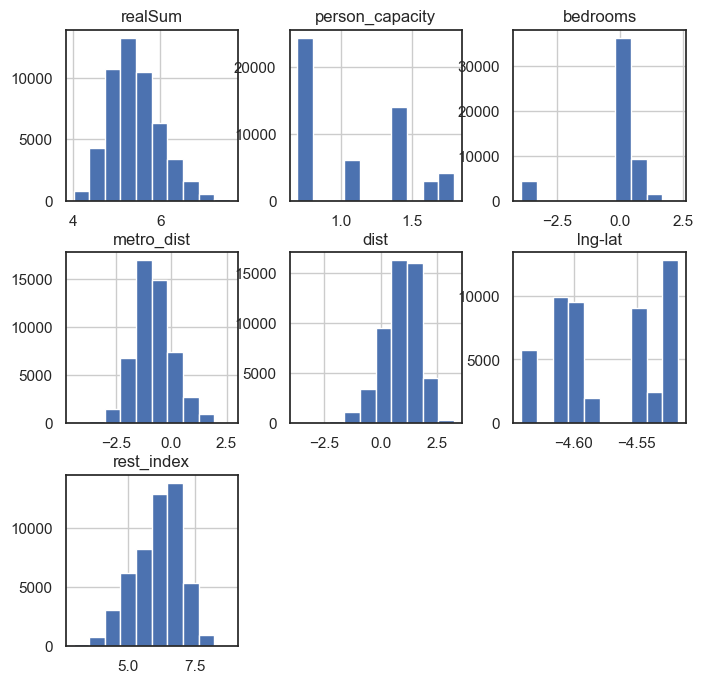

In [1366]:
# Comparing the features distribution
df[num_cols].hist(figsize=(8, 8))
plt.show()

In [1367]:
# Removing dropped columns from the list of categorical columns
cat_cols = [col for col in df.columns if col not in num_cols]

In [1368]:
# Defining the features and target
X = df.drop('realSum', axis=1)
y = df.realSum

# Scaling the features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [1369]:
# Split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [1370]:
def get_scores(y_train, train_pred, y_val, val_pred):
    print("\nTraining MSE:", round(mean_squared_error(y_train, train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_val, val_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, train_pred),4))
    print("Validation r2:", round(r2_score(y_val, val_pred),4))

    # Calculate the difference between the training and validation scores
    print("\nMSE training-validation gap:", abs(round(mean_squared_error(y_train, train_pred) - mean_squared_error(y_val, val_pred),4)))
    print("r2 training-validation gap:", abs(round(r2_score(y_train, train_pred) - r2_score(y_val, val_pred),4)))

In [1371]:
xgb_start = time()

# Instantiate the model (Used hyperparameter tuning by GridSearchCV for best parameters)
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01, reg_lambda=0.005, reg_alpha=0.005, n_jobs=4, early_stopping_rounds=5, random_state=42)

# Fit the model
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predict on the training set
train_pred = xgb.predict(X_train)

# Predict on the validation set
val_pred = xgb.predict(X_val)

xgb_end = time()

# Calculate the scores
print(f"Time taken to run: {round((xgb_end - xgb_start)/60,1)} minutes")
get_scores(y_train, train_pred, y_val, val_pred)

Time taken to run: 0.2 minutes

Training MSE: 0.071
Validation MSE: 0.0798

Training r2: 0.7881
Validation r2: 0.7607

MSE training-validation gap: 0.0088
r2 training-validation gap: 0.0273


In [1372]:
# Get the feature importances from the XGBoost model
ft_weights_xgb = pd.DataFrame(xgb.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb.sort_values('weight', inplace=True)
ft_weights_xgb

,weight
multi_1,0.005670
host_is_superhost_True,0.006476
metro_dist,0.007242
dist,0.014473
biz_1,0.024037
guest_satisfaction_overall_95-100/100,0.030149
rest_index,0.045246
room_type_Shared room,0.080192
person_capacity,0.093228
bedrooms,0.110467


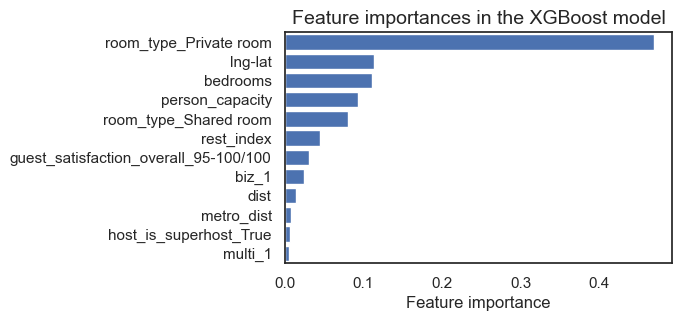

In [1373]:
# Plot the feature importances in the XGBoost model
plt.figure(figsize=(5,3))
plt.barh(ft_weights_xgb.index, ft_weights_xgb.weight, align='center')
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

[Text(0, 2.0, ''),
 Text(0, 3.0, ''),
 Text(0, 4.0, ''),
 Text(0, 5.0, ''),
 Text(0, 6.0, ''),
 Text(0, 7.0, ''),
 Text(0, 8.0, ''),
 Text(0, 9.0, '')]

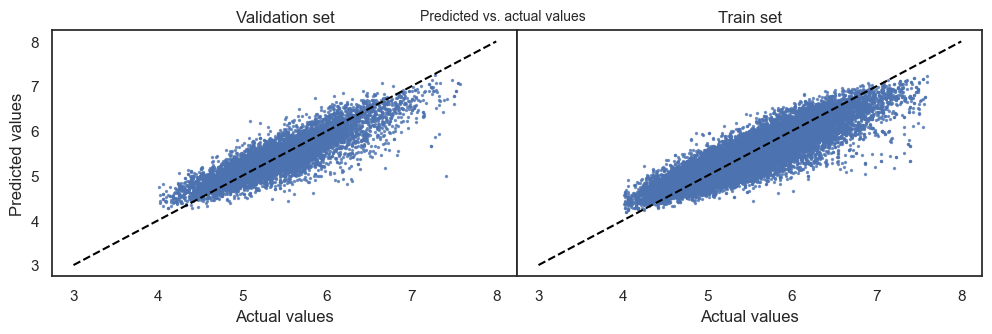

In [1374]:
# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
fig.suptitle('Predicted vs. actual values', fontsize=10, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

# Plot the scatter-plot of the validation set
ax1.scatter(y_val, val_pred, s=2, alpha=0.7)
ax1.plot(list(range(3, 9)), list(range(3, 9)), color='black', linestyle='--')
ax1.set_title('Validation set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')

# Plot the scatter-plot of the training set
ax2.scatter(y_train, train_pred, s=2, alpha=0.7)
ax2.plot(list(range(3, 9)), list(range(3, 9)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')

[Text(0, 0.0, ''),
 Text(0, 500.0, ''),
 Text(0, 1000.0, ''),
 Text(0, 1500.0, ''),
 Text(0, 2000.0, ''),
 Text(0, 2500.0, ''),
 Text(0, 3000.0, ''),
 Text(0, 3500.0, ''),
 Text(0, 4000.0, '')]

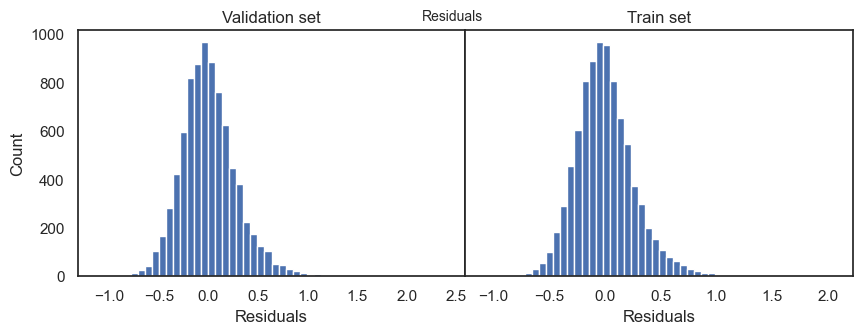

In [1375]:
# Plotting training and validation residuals side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Residuals', fontsize=10, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

# Create a histogram of the residuals
ax1.hist(y_val - val_pred, bins=50)
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Count')
ax1.set_title('Validation set')

# Create a histogram of the residuals
ax2.hist(y_train - train_pred, bins=50)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Count')
ax2.set_title('Train set')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')

In [1376]:
rf_start = time()

# Instantiate the model
rf = RandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_split=10, min_samples_leaf=10, n_jobs=4, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict on the training set
train_pred = rf.predict(X_train)

# Predict on the validation set
val_pred = rf.predict(X_val)

rf_end = time()

# Calculate the scores
print(f"Time taken to run: {round((rf_end - rf_start) / 60, 1)} minutes")
get_scores(y_train, train_pred, y_val, val_pred)

Time taken to run: 0.3 minutes

Training MSE: 0.075
Validation MSE: 0.0838

Training r2: 0.776
Validation r2: 0.7485

MSE training-validation gap: 0.0088
r2 training-validation gap: 0.0274
